# Fixed Point Regression

Heavily adopted from python scripts for research purposes from this repo: https://github.com/satyenrajpal/speed-prediction-challenge <br>
and this paper: https://ieeexplore.ieee.org/document/6960689

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker

def movingAverage(x, window):
    ret = np.zeros_like(x)

    for i in range(len(x)):
        idx1 = max(0, i - (window - 1) // 2)
        idx2 = min(len(x), i + (window - 1) // 2 + (2 - (window % 2)))

        ret[i] = np.mean(x[idx1:idx2])

    return ret

def computeAverage(x, window, idx):

    min_idx = max(0, idx - window - 1)
    return np.mean(x[min_idx:idx])

def plot(predict_values, gt):
    fig, ax = plt.subplots()
    ax.plot(np.arange(len(gt)), gt, label='ground truth')
    ax.plot(np.arange(len(predict_values)), np.array(predict_values), label='predict')
    start, end = ax.get_xlim()
    ax.yaxis.set_ticks(np.arange(0, max(gt) +10,  5.0))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
    ax.legend(loc='upper left')
    plt.xlabel('Frame num.')
    plt.ylabel('Speed')
    # ax.figure.savefig('result.png', bbox_inches='tight')
    plt.show()

In [2]:
import cv2, os
import numpy as np
import sys
from sklearn import linear_model
from collections import defaultdict
FPS = 20

class Solver():
    def __init__(self):
        """
        data parameters
        """
        self.vis = True
        self.train_path = '../data/train/' #train file path
        self.val_path = '../data/val/'
        holdout_path = '../data/holdout/'
        self.test_path = '../data/test/'
        
        self.train_csv = pd.read_csv(self.train_path + 'train_meta.csv')
        self.val_csv = pd.read_csv(self.val_path + 'val_meta.csv')
        holdout_csv = pd.read_csv(holdout_path + 'holdout_meta.csv')
        self.val_csv = pd.concat([self.val_csv, holdout_csv], ignore_index = True)
        self.test_csv = pd.read_csv(self.test_path + 'test_meta.csv')

        """ 
        tracking and extracting features parameters
        """
        self.len_gt = len(self.train_csv) + len(self.val_csv) #length of the ground truth labels
            
        self.vis_images = defaultdict(list)
        self.vis_length = FPS*5
        
        # Lucas Kanade parameters
        self.lk_params = dict(winSize = (21, 21),
                              maxLevel = 2,
                              criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 20, 0.01))

        self.frame_idx = 0
        self.prev_pts = None
        self.detect_interval = 1
        self.temp_preds = np.zeros(self.len_gt)
        self.gt = np.array(list(self.train_csv['speed']) + list(self.val_csv['speed']))
        
        self.window = 80 # for moving average
        self.prev_gray = None

    def constructMask(self, mask = None):
        """Constructs a mask to only take into consideration a part of the frame.
        In this case it's the road. """
        
        if mask is None:
            H, W, C = cv2.imread(self.train_csv.iloc[0]['image_path']).shape
            h, w, c = cv2.imread(self.test_csv.iloc[0]['image_path']).shape

            assert H == h, "Train image height does not match test"
            assert W == w, 'Train image width does not matching test'
            mask = np.zeros(shape = (H,W), dtype = np.uint8)
            mask.fill(255)
        else:
            W = mask.shape[1]
            H = mask.shape[0]

        cv2.rectangle(mask, (0, 0), (W, H), (0, 0, 0), -1)

        x_top_offset = 240
        x_btm_offset = 65

        poly_pts = np.array([[[640-x_top_offset, 250], [x_top_offset, 250], [x_btm_offset, 350], [640-x_btm_offset, 350]]], dtype=np.int32)
        cv2.fillPoly(mask, poly_pts, (255, 255, 255))

        return mask


    def processFrame(self, frame):
        """ Gaussian Blur and then apply Lucas Kanade optical flow"""
        frame = cv2.GaussianBlur(frame, (3,3), 0)
        
        curr_pts, _st, _err = cv2.calcOpticalFlowPyrLK(self.prev_gray, frame, self.prev_pts, None, **self.lk_params)
        # Store flow (x, y, dx, dy)
        flow = np.hstack((self.prev_pts.reshape(-1, 2), (curr_pts - self.prev_pts).reshape(-1, 2)))

        preds = []
        for x, y, u, v in flow:
            if v < -0.05:
                continue
            # Translate points to center
            x -= frame.shape[1]/2
            y -= frame.shape[0]/2

            # Append to preds taking care of stability issues
            if y == 0 or (abs(u) - abs(v)) > 11:
                preds.append(0)
                preds.append(0)
            elif x == 0:
                preds.append(0)
                preds.append(v / (y*y))
            else:
                preds.append(u / (x * y))
                preds.append(v / (y*y))

        return [n for n in preds if n>=0]

    def getKeyPts(self, offset_x=0, offset_y=0):
        """ return key points with offset """
        if self.prev_pts is None:
            return None
        return [cv2.KeyPoint(x=p[0][0] + offset_x, y=p[0][1] + offset_y, _size=10) for p in self.prev_pts]
    
    def getFeatures(self, frame_gray, mask):
        return cv2.goodFeaturesToTrack(frame_gray,30,0.1,10,blockSize=10,
                                                    mask=mask)

    def get_preds(self, source, img_paths):
        mask = self.constructMask()
        prev_key_pts = None
        
        for image_path in img_paths:
            frame = cv2.imread(image_path)

            # Convert to B/W
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame_gray = frame_gray[130:350, 35:605]
            
            mask_vis = frame.copy() # <- For visualization
            
            # Process each frame
            if self.prev_pts is None:
                self.temp_preds[self.frame_idx] = 0
            else:
                # Get median of predicted V/hf values
                preds = self.processFrame(frame_gray)
                self.temp_preds[self.frame_idx] = np.median(preds) if len(preds) else 0

            # Extract features
            self.prev_pts = self.getFeatures(frame_gray, mask[130:350, 35:605])
            self.prev_gray = frame_gray
            self.frame_idx += 1
            
            # For visualization purposes only
            if self.vis:
                prev_key_pts = self.visualize(frame, mask_vis, prev_key_pts, source=source)
            
    def test(self):
        source = 'test'
        
        test_preds = np.zeros(len(self.test_csv))
        mask = self.constructMask()
        prev_key_pts = None
        for image_path in img_paths:
            frame = cv2.imread(image_path)

            # Convert to B/W
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame_gray = frame_gray[130:350, 35:605]
            
            mask_vis = frame.copy() # <- For visualization
            
            # Process each frame
            if self.prev_pts is None:
                test_preds[self.frame_idx] = 0
            else:
                # Get median of predicted V/hf values
                preds = self.processFrame(frame_gray)
                test_preds[self.frame_idx] = np.median(preds) if len(preds) else 0

            # Extract features
            self.prev_pts = self.getFeatures(frame_gray, mask[130:350, 35:605])
            self.prev_gray = frame_gray
            self.frame_idx += 1
            
            # For visualization purposes only
            if self.vis:
                prev_key_pts = self.visualize(frame, mask_vis, prev_key_pts, source=source)
                
        pred_speed_test = test_preds * self.hf_factor
        pred_speed_test = movingAverage(pred_speed_test, self.window)
        self.test_csv['speed'] = pred_speed_test
        
    def run(self):
        # get train preds
        self.get_preds('train', list(self.train_csv['image_path']))
        
        # get val preds
        self.get_preds('val', list(self.val_csv['image_path']))
                
        # Split predictions into train and validation - 
        train_indxs = slice(0, len(self.train_csv))
        val_indxs = slice(train_indxs.stop, train_indxs.stop + len(self.val_csv))
        assert val_indxs.stop == self.frame_idx
        
        train_preds = self.temp_preds[train_indxs]
        val_preds = self.temp_preds[val_indxs]
        
        self.y_train = self.gt[train_indxs]
        self.y_val = self.gt[val_indxs]

        # Fit to ground truth
        preds = movingAverage(train_preds, self.window)
        
        lin_reg = linear_model.LinearRegression(fit_intercept=False)
        lin_reg.fit(preds.reshape(-1, 1), self.y_train) 
        hf_factor = lin_reg.coef_[0]
        print("Estimated hf factor = {}".format(hf_factor))
        
        # estimate training error
        pred_speed_train = train_preds * hf_factor
        self.y_train_preds = movingAverage(pred_speed_train, self.window)
        mse = np.mean((self.y_train_preds - self.y_train)**2)
        print("MSE for train", mse)

        # Estimate validation error
        pred_speed_val = val_preds * hf_factor
        self.y_val_preds = movingAverage(pred_speed_val, self.window)
        mse = np.mean((self.y_val_preds - self.y_val)**2)
        print("MSE for val", mse)
        
        self.hf_factor = hf_factor
        self.test
        
    def visualize(self, frame, mask_vis, prev_key_pts, source, speed=None):
        assert type(source) == str
        if(len(self.vis_images[source]) >= self.vis_length):
            #done appending to self.vis_images
            return
        
        self.constructMask(mask_vis)
        
        mask_vis = cv2.bitwise_not(mask_vis)
        frame_vis = cv2.addWeighted(frame, 1, mask_vis, 0.3, 0)
        key_pts = self.getKeyPts(35, 130)
        cv2.drawKeypoints(frame_vis, key_pts, frame_vis, color=(0,0,255))
        cv2.drawKeypoints(frame_vis, prev_key_pts, frame_vis, color=(0,255,0))

        if speed is not None:
            font = cv2.FONT_HERSHEY_DUPLEX
            cv2.putText(frame_vis, "speed {}".format(speed), (10, 35), font, 1.2, (0, 0, 255))
        
        self.vis_images[source].append(cv2.cvtColor(frame_vis, cv2.COLOR_BGR2RGB))

        return key_pts

In [3]:
import cv2, os
import sys
import argparse
#from solver import Solver

def str2bool(v):
    return v.lower() in ('true')

def main():
    solver = Solver()
    solver.run()
    
    return solver

In [4]:
run = True
if run:
    solver = main()

Estimated hf factor = 6460.655084570087
MSE for train 5.369653483959768
MSE for val 1.3205408232631681


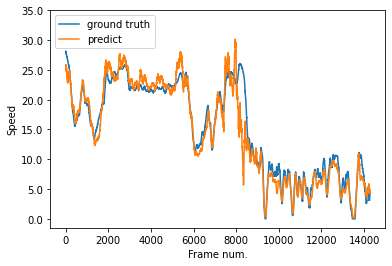

In [5]:
plot(solver.y_train_preds, solver.y_train)

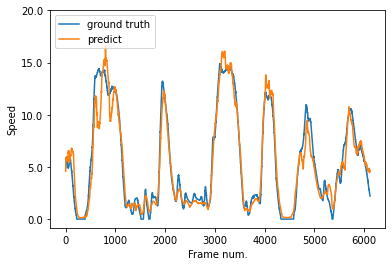

In [6]:
plot(solver.y_val_preds, solver.y_val)

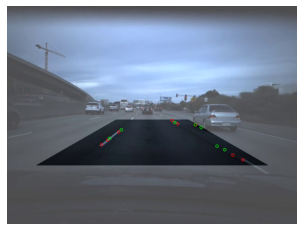

In [7]:
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import glob

%matplotlib inline

def plot_images(img_list):
    def init():
        img.set_data(img_list[0])
        return (img,)

    def animate(i):
        img.set_data(img_list[i])
        return (img,)

    fig = plt.figure()
    ax = fig.gca()
    ax.axis('off')
    img = ax.imshow(img_list[0])
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                 frames=len(img_list), interval=1000/FPS, blit=True)
    return anim

imgs = solver.vis_images['train']

HTML(plot_images(imgs).to_html5_video())

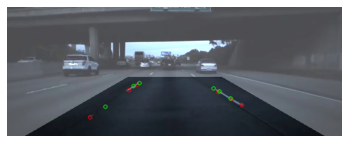

In [8]:
plt.axis('off')
plt.imshow(imgs[1][130:350, 35:605])